In [1]:
# Imports
import os
import sys
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
import sys
sys.path.append("../scripts")

import utils
from utils import load_sar_spectrum, calculate_wave_parameters, plot_directional_spectrum

## 1. Configuration and Data Loading

In [20]:
# SAR file parameters
file_path = '/Users/jtakeo/data/sentinel1ab/freddy/dataset-wav-sar-l3-spc-nrt-global-s1a_20230212T120000Z_20230212T150000Z_P20230227T0226Z-3H-rep.nc'
grp = "obs_params"

# Spatial index (location in file)
index = 354

# Reference timestamp (close to WW3 for comparison)
date_time = "2023-02-12T15:00:00Z"

# Open dataset
ds = xr.open_dataset(file_path, group=grp)

print(f"Dataset loaded successfully!")
print(f"Dimensions: {dict(ds.dims)}")
# print(f"\nMain variables:")
# for var in ['wave_spec', 'VAVH', 'VTPK', 'VPED']:
#     if var in ds.variables:
#         print(f"  - {var}: {ds[var].shape}")

     
print(ds.partition_domain_spec.values[0,:,:])

Dataset loaded successfully!
Dimensions: {'obs': 389, 'spectrum_wavenumber': 60, 'spectrum_direction': 72}
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


/var/folders/cp/8th3fpl14tz3yqc3hyy8bksc0000gq/T/ipykernel_1366/2383488777.py:15: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"Dimensions: {dict(ds.dims)}")


## 1.1 Análise das Partições SAR

O arquivo SAR já contém partições identificadas na variável `partition_domain_spec`.

In [21]:
# Analisar partições SAR originais
partition_map = ds.partition_domain_spec[:, :, index].values

# Descobrir quantas partições existem
unique_partitions = np.unique(partition_map)
partition_ids = unique_partitions[unique_partitions > 0]
n_sar_partitions = len(partition_ids)

print("="*70)
print(" PARTIÇÕES SAR ORIGINAIS (do arquivo)")
print("="*70)
print(f"\nIndex: {index}")
print(f"Número de partições identificadas pelo SAR: {n_sar_partitions}")
print(f"IDs das partições: {partition_ids}")

# Estatísticas de cada partição
for pid in partition_ids:
    n_points = np.sum(partition_map == pid)
    pct = 100 * n_points / partition_map.size
    print(f"\nPartição {int(pid)}:")
    print(f"  Pontos espectrais: {n_points} ({pct:.1f}% do espectro)")

# Pontos não classificados
n_unclassified = np.sum(partition_map == 0)
pct_unclassified = 100 * n_unclassified / partition_map.size
print(f"\nPontos não classificados (valor 0): {n_unclassified} ({pct_unclassified:.1f}%)")

print("\n" + "="*70)
print(f"⚠️  SAR original identifica apenas {n_sar_partitions} partição(ões)")
print(f"    Seu algoritmo watershed pode encontrar mais partições")
print("="*70)

 PARTIÇÕES SAR ORIGINAIS (do arquivo)

Index: 354
Número de partições identificadas pelo SAR: 1
IDs das partições: [1]

Partição 1:
  Pontos espectrais: 608 (14.1% do espectro)

Pontos não classificados (valor 0): 3712 (85.9%)

⚠️  SAR original identifica apenas 1 partição(ões)
    Seu algoritmo watershed pode encontrar mais partições


In [22]:
# Extrair parâmetros das partições SAR (Hs, Tp, Dp)
print("\n" + "="*70)
print(" PARÂMETROS DAS PARTIÇÕES SAR (Hs, Tp, Dp)")
print("="*70)

# Para cada partição SAR identificada, calcular seus parâmetros
# integrando apenas os pontos espectrais que pertencem a ela

for pid in partition_ids:
    # Criar máscara para esta partição
    mask = (partition_map == pid)
    
    # Criar espectro apenas com esta partição
    E2d_partition = np.zeros_like(E2d)
    E2d_partition[mask] = E2d[mask]
    
    # Calcular parâmetros integrados desta partição
    hs_part, tp_part, dp_part, m0_part, _, _, _, _ = calculate_wave_parameters(
        E2d_partition, freq, dirs_rad
    )
    
    energy_part = m0_part
    energy_fraction = 100 * energy_part / m0 if m0 > 0 else 0
    
    print(f"\nPartição {int(pid)}:")
    print(f"  Hs = {hs_part:.2f} m")
    print(f"  Tp = {tp_part:.2f} s")
    print(f"  Dp = {dp_part:.0f}°")
    print(f"  Energia = {energy_part:.6f} m²")
    print(f"  Fração da energia total: {energy_fraction:.1f}%")

# Comparar com valores do arquivo SAR (VAVH, VTPK, VPED)
print("\n" + "─"*70)
print("📁 Valores do arquivo SAR (VAVH, VTPK, VPED):")
print(f"  Hs = {vavh_sar:.2f} m")
print(f"  Tp = {vtpk_sar:.2f} s")
print(f"  Dp = {vped_sar:.0f}°")

print("\n" + "="*70)
print("⚠️  Nota: VAVH/VTPK/VPED representam a partição dominante")
print("    identificada pelo algoritmo do SAR L3")
print("="*70)


 PARÂMETROS DAS PARTIÇÕES SAR (Hs, Tp, Dp)

Partição 1:
  Hs = 1.50 m
  Tp = 14.84 s
  Dp = 60°
  Energia = 0.140886 m²
  Fração da energia total: 82.3%

──────────────────────────────────────────────────────────────────────
📁 Valores do arquivo SAR (VAVH, VTPK, VPED):
  Hs = 1.61 m
  Tp = 14.68 s
  Dp = -164°

⚠️  Nota: VAVH/VTPK/VPED representam a partição dominante
    identificada pelo algoritmo do SAR L3


## 2. Load and Convert SAR Spectrum

Conversion from **E(k,θ) [m⁴]** to **E(f,θ) [m²·s·rad⁻¹]** using:
- Dispersion relation Jacobian: `dk/df = 8π²f/g`
- Angular conversion: `π/180` (degrees → radians)

In [3]:
# Reload utils module to get latest changes (e.g., colormap updates)
importlib.reload(utils)
from utils import load_sar_spectrum, calculate_wave_parameters, plot_directional_spectrum

# Load SAR spectrum and convert to m²·s·rad⁻¹
# IMPORTANT: Pass date_time=None to use spatial index directly
E2d, freq, dirs, dirs_rad, selected_time = load_sar_spectrum(ds, date_time=None, index=index)

print(f"\nSpectrum loaded:")
print(f"  Spatial index used: {index}")

print(f"  Timestamp (from index {index}): {selected_time}")
print(f"  Directions: {len(dirs)} bins ({dirs[0]:.1f}° - {dirs[-1]:.1f}°)")

print(f"  E2d shape: {E2d.shape}")
print(f"  Frequencies: {len(freq)} bins ({freq[0]:.4f} - {freq[-1]:.4f} Hz)")

Variáveis disponíveis no arquivo SAR: ['L2_source_product', 'VPED', 'snr', 'VTPK', 'partition_domain_spec', 'VPED_flag', 'L2_partition_quality_flag', 'n_posneg', 'n_box', 'direction_spec', 'longitude', 'inten', 'VAVH_flag', 'wavenumber_spec', 'storm_id', 'latitude', 'nv', 'VTPK_flag', 'VAVH', 'time', 'resolution_spec', 'wave_spec']
Usando arquivo preprocessado (CMEMS), shape E_sar: (60, 72)
Shape k: (60,)
Shape phi: (72,)
╔══════════════════════════════════════════════════════════════╗
║         CONVERSÃO SAR: m⁴ → m²·s·rad⁻¹ (WW3 units)          ║
╠══════════════════════════════════════════════════════════════╣
║ Shape:                                             (60, 72) ║
║ Frequências: 60 bins | Direções: 72 bins              ║
║ Freq range: 0.0361 - 0.2281 Hz                       ║
║ Dir range: 0.0° - 355.0°                            ║
╟──────────────────────────────────────────────────────────────╢
║ Jacobiano dk/df: 0.2903 - 1.8361                   ║
║ Fator angular (π/180): 

## 3. Calculate Integrated Parameters

In [4]:
# Calculate Hs, Tp, Dp using trapezoidal integration
hs, tp, dp, m0, delf, ddir, i_peak, j_peak = calculate_wave_parameters(E2d, freq, dirs_rad)

# SAR file parameters using SPATIAL INDEX (index)
# IMPORTANT: index is the spatial location (lon/lat), NOT temporal
vavh_sar = ds.VAVH[index].values
vtpk_sar = ds.VTPK[index].values
vped_sar = ds.VPED[index].values
quality_flag = ds.L2_partition_quality_flag[index].values
actual_time = pd.to_datetime(ds.time[index].values)

# Geographic coordinates
lon = ds.longitude[index].values if 'longitude' in ds else None
lat = ds.latitude[index].values if 'latitude' in ds else None

# Summary
print("\n" + "="*70)
print(" SAR SPECTRUM INTEGRATED PARAMETERS")
print("="*70)
print(f"Location: index = {index}")
if lon is not None and lat is not None:
    print(f"Coordinates: {lon:.2f}°E, {lat:.2f}°N")
print(f"Timestamp: {actual_time}")
print(f"Quality Flag: {quality_flag}")
print("─"*70)

print(f"\n📊 Calculated (trapezoidal integration):")
print(f"   m0 = {m0:.6f} m²")
print(f"   Hs = {hs:.2f} m")
print(f"   Tp = {tp:.2f} s")
print(f"   Dp = {dp:.0f}°")

print(f"\n📁 SAR File (VAVH/VTPK/VPED for index={index}):")
print(f"   Hs = {vavh_sar:.2f} m")
print(f"   Tp = {vtpk_sar:.2f} s")
print(f"   Dp = {vped_sar:.0f}°")

print(f"\n✓ Hs Error (calculated vs file): {abs(hs - vavh_sar)/vavh_sar*100:.1f}%")
print("="*70)


 SAR SPECTRUM INTEGRATED PARAMETERS
Location: index = 354
Coordinates: 88.54°E, -15.98°N
Timestamp: 2023-02-12 12:27:02
Quality Flag: 0.0
──────────────────────────────────────────────────────────────────────

📊 Calculated (trapezoidal integration):
   m0 = 0.171276 m²
   Hs = 1.66 m
   Tp = 14.84 s
   Dp = 62°

📁 SAR File (VAVH/VTPK/VPED for index=354):
   Hs = 1.61 m
   Tp = 14.68 s
   Dp = -164°

✓ Hs Error (calculated vs file): 3.0%


## 4. Spectral Partitioning

Apply partitioning algorithm to separate wave systems (wind sea and swells).

In [7]:
# Import partitioning function
import importlib
import partition
importlib.reload(partition)
from partition import partition_spectrum

# Apply partitioning
results = partition_spectrum(E2d, freq, dirs_rad, 0.05, 5)

if results is None:
    print("No spectral peaks identified!")
else:
    # Partitioning process information
    n_peaks_initial = len(results['peaks'])
    
    # Count how many partitions really have significant energy (> 1% of total)
    min_energy_threshold = 0.01 * results['total_m0']  # 1% of total energy
    n_partitions_final = 0
    for i in range(1, len(results['Hs'])):
        if results['energy'][i] > min_energy_threshold:
            n_partitions_final += 1
    
    print("\n" + "="*70)
    print(" SPECTRAL PARTITIONING - PROCESS SUMMARY")
    print("="*70)
    print(f"🔍 Spectral peaks initially identified: {n_peaks_initial}")
    print(f"🔗 After merging nearby systems: {n_partitions_final} partition(s)")
    print("="*70)
    
    print("\n" + "="*70)
    print(" PARTITIONING RESULTS")
    print("="*70)
    print(f"Number of partitions found: {n_partitions_final}")
    print("─"*70)
    
    # Display information for each partition that actually exists
    partition_count = 0
    for i in range(1, len(results['Hs'])):
        if results['energy'][i] > min_energy_threshold:  # Only significant energy
            partition_count += 1
            print(f"\nPartition {partition_count}:")
            print(f"  Hs = {results['Hs'][i]:.2f} m")
            print(f"  Tp = {results['Tp'][i]:.2f} s")
            print(f"  Dp = {results['Dp'][i]:.0f}°")
            print(f"  Energy: {results['energy'][i]:.4f} m²")
            print(f"  Energy fraction: {(results['energy'][i]/results['total_m0'])*100:.1f}%")
    
    print("\n" + "─"*70)
    print(f"Integrated total:")
    print(f"  Hs = {results['total_Hs']:.2f} m")
    print(f"  Tp = {results['total_Tp']:.2f} s")
    print(f"  Dp = {results['total_Dp']:.0f}°")
    print("="*70)

Identifying spectral peaks with threshold: 5.00e-02
Spectrum values: min=0.00e+00, max=1.33e+01, mean=1.99e-01
Limiting number of peaks from 29 to 5
Identified 5 spectral peaks
Generating mask from ICOD...
Calculating distances between peaks...
Calculating peak spreading...
Checking for overlapping systems...
Number of masks: 5
[DEBUG] Sum of partition energies: 0.173973
[DEBUG] Expected total: 0.173973
Total spectrum energy: 0.171276
Sum of partitioned energies: 0.173973

 SPECTRAL PARTITIONING - PROCESS SUMMARY
🔍 Spectral peaks initially identified: 5
🔗 After merging nearby systems: 5 partition(s)

 PARTITIONING RESULTS
Number of partitions found: 5
──────────────────────────────────────────────────────────────────────

Partition 1:
  Hs = 1.36 m
  Tp = 14.84 s
  Dp = 54°
  Energy: 0.1151 m²
  Energy fraction: 67.2%

Partition 2:
  Hs = 0.65 m
  Tp = 14.84 s
  Dp = 36°
  Energy: 0.0268 m²
  Energy fraction: 15.6%

Partition 3:
  Hs = 0.64 m
  Tp = 9.58 s
  Dp = 279°
  Energy: 0.0253 

## 5. Visualização: Espectro Direcional 2D

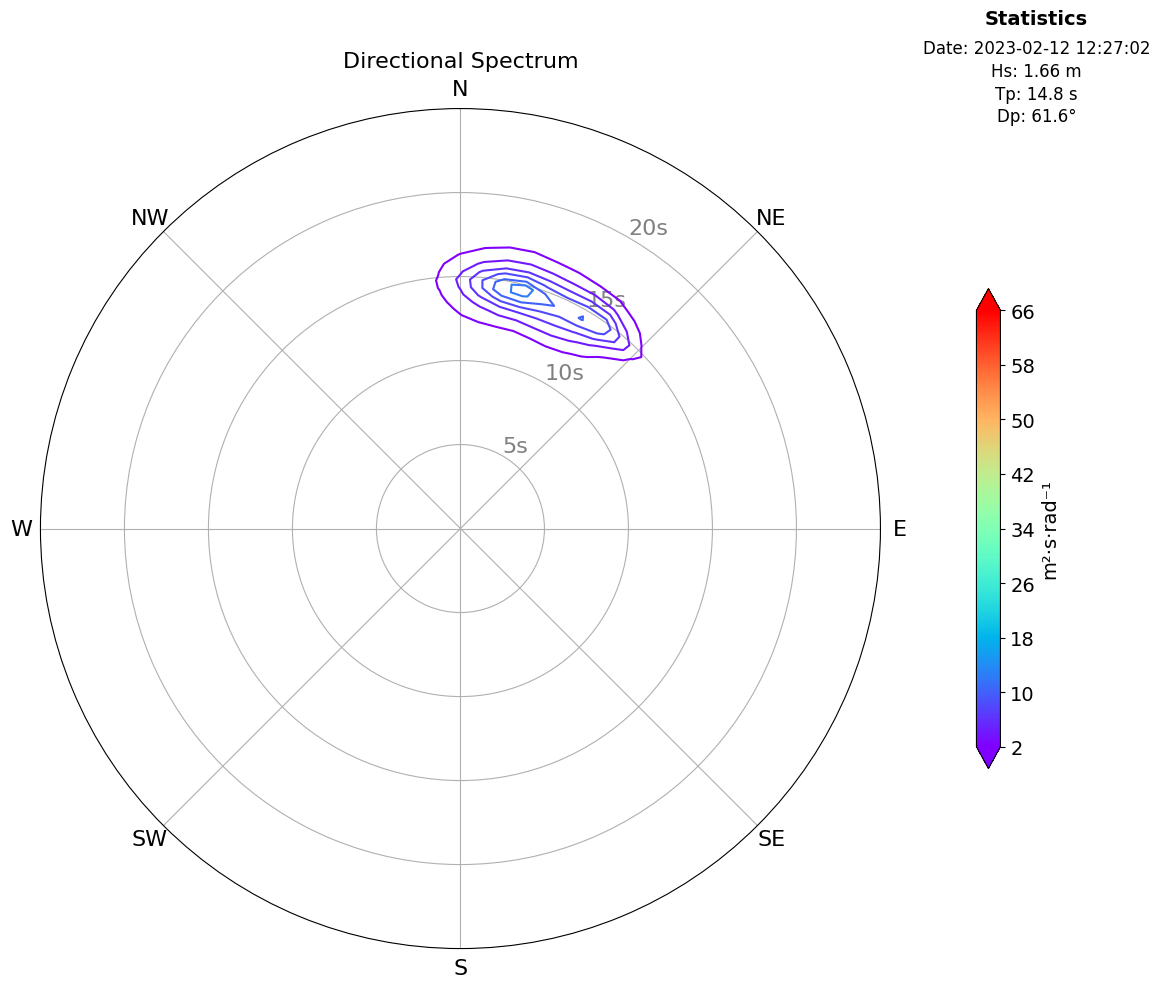

In [8]:
# Plot do espectro direcional 2D em coordenadas polares
fig, ax = plot_directional_spectrum(
    E2d, 
    freq, 
    dirs,
    selected_time=selected_time,
    hs=hs,
    tp=tp,
    dp=dp
)

plt.show()

## 6. Análise Espectral Adicional

Espectro 1D de frequência e análise por direção.

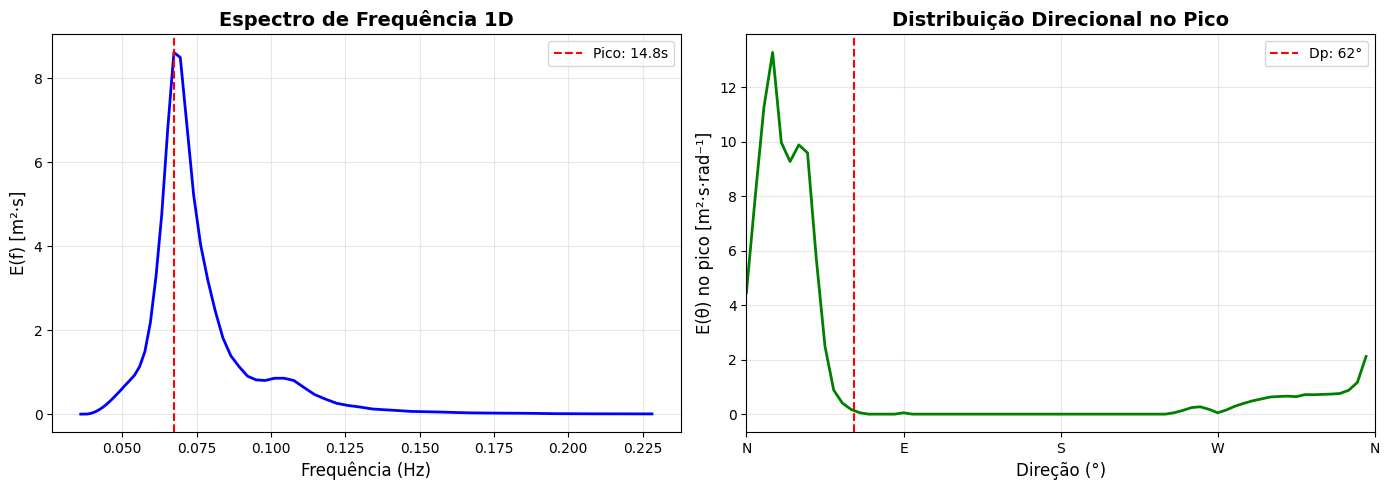

In [9]:
from utils import spectrum1d_from_2d

# Calcular espectro 1D
spec1d, ddir = spectrum1d_from_2d(E2d, dirs_rad)

# Plot espectro 1D
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Espectro de frequência
ax1.plot(freq, spec1d, 'b-', linewidth=2)
ax1.axvline(freq[i_peak], color='r', linestyle='--', label=f'Pico: {1/freq[i_peak]:.1f}s')
ax1.set_xlabel('Frequência (Hz)', fontsize=12)
ax1.set_ylabel('E(f) [m²·s]', fontsize=12)
ax1.set_title('Espectro de Frequência 1D', fontsize=14, weight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Distribuição direcional no pico
ax2.plot(dirs, E2d[i_peak, :], 'g-', linewidth=2)
ax2.axvline(dp, color='r', linestyle='--', label=f'Dp: {dp:.0f}°')
ax2.set_xlabel('Direção (°)', fontsize=12)
ax2.set_ylabel('E(θ) no pico [m²·s·rad⁻¹]', fontsize=12)
ax2.set_title('Distribuição Direcional no Pico', fontsize=14, weight='bold')
ax2.set_xlim(0, 360)
ax2.set_xticks([0, 90, 180, 270, 360])
ax2.set_xticklabels(['N', 'E', 'S', 'W', 'N'])
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

## 7. Comparação com Referências

Comparar resultados SAR com dados de referência (WW3, arquivo VAVH).

In [10]:
# Dados de referência WW3 (para este horário)
hs_ww3 = 2.49
tp_ww3 = 12.83
dp_ww3 = 186

# Criar tabela comparativa
import pandas as pd

comparison = pd.DataFrame({
    'Fonte': ['SAR Calculado', 'WW3'],
    'Hs (m)': [hs, hs_ww3],
    'Tp (s)': [tp, tp_ww3],
    'Dp (°)': [dp, dp_ww3]
})

print("\n" + "="*70)
print(" Comparing SAR Calculated vs WW3 for this location/time case")
print("="*70)
print(comparison.to_string(index=False))
print("─"*70)

# Erros relativos
print(f"\nWW3 difference related to SAR calculated:")
print(f"  ΔHs = {(hs_ww3 - hs)/hs_ww3*100:.1f}%")
print(f"  ΔTp = {(tp_ww3 - tp)/tp_ww3*100:.1f}%")
print(f"  ΔDp = {abs(dp_ww3 - dp)/dp_ww3*100:.1f}%")


 Comparing SAR Calculated vs WW3 for this location/time case
        Fonte   Hs (m)    Tp (s)     Dp (°)
SAR Calculado 1.655421 14.835781  61.638943
          WW3 2.490000 12.830000 186.000000
──────────────────────────────────────────────────────────────────────

WW3 difference related to SAR calculated:
  ΔHs = 33.5%
  ΔTp = -15.6%
  ΔDp = 66.9%


# Plot partition(s)

/var/folders/cp/8th3fpl14tz3yqc3hyy8bksc0000gq/T/ipykernel_1366/3642597063.py:31: UserWarning: The following kwargs were not used by contour: 'label'
  cs = ax2.contour(theta, r, E_part, levels=levels_part,


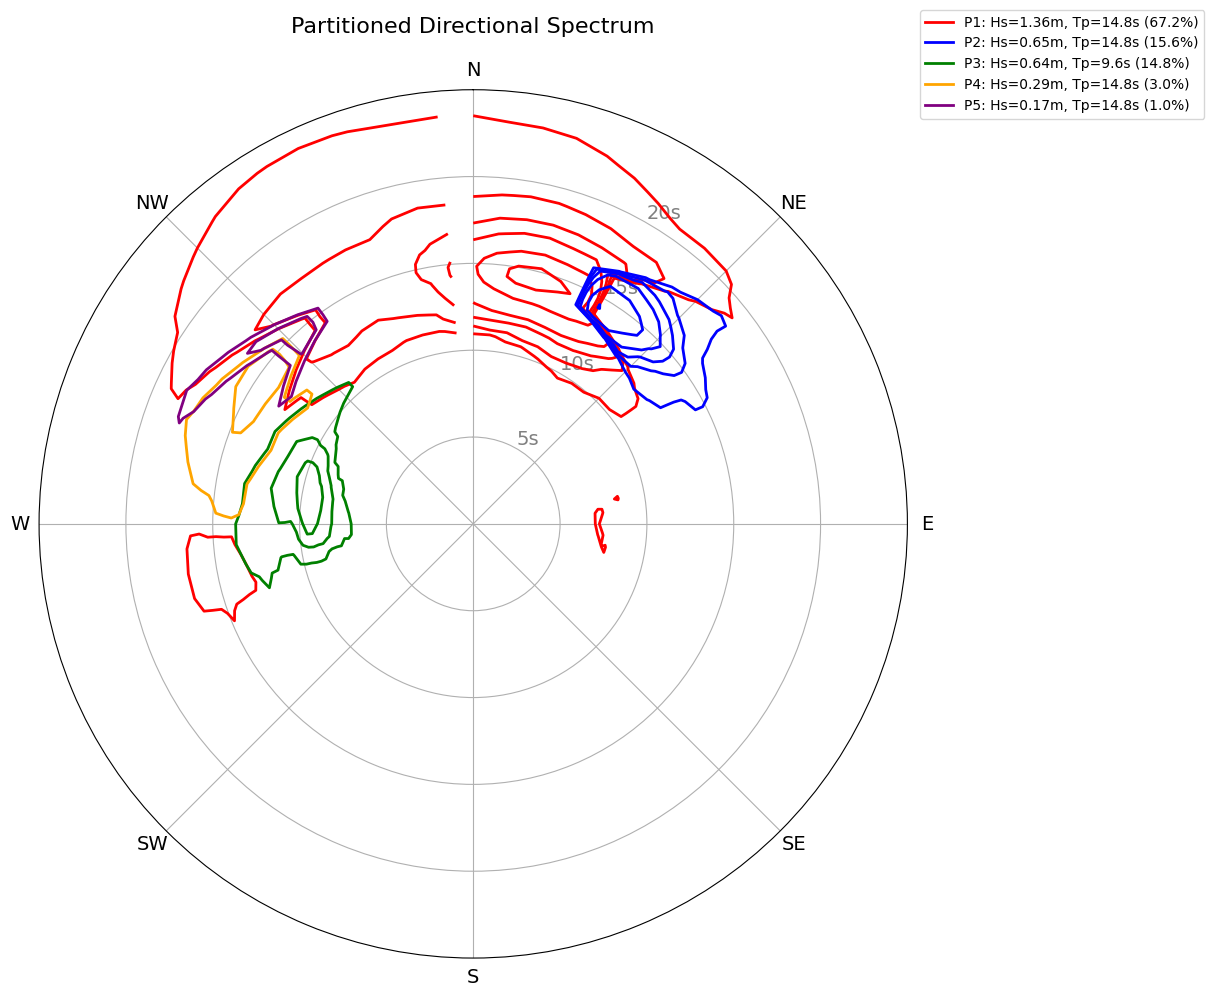

In [11]:
# Plot das partições individuais no espectro polar
fig2, ax2 = plt.subplots(figsize=(12, 10), subplot_kw=dict(projection='polar'))

# Preparar dados
freq_plot = np.asarray(freq).flatten()
dirs_plot = np.asarray(dirs).flatten()
dirs_rad_plot = np.radians(dirs_plot)

# Converter para período
with np.errstate(divide='ignore', invalid='ignore'):
    period = np.where(freq_plot > 0, 1.0 / freq_plot, 0)

# Criar meshgrid
theta, r = np.meshgrid(dirs_rad_plot, period)

# Cores para cada partição
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow']
min_energy_threshold = 0.01 * results['total_m0']  # 1% para mostrar todas as partições significativas

# Plotar contornos de cada partição
partition_count = 0
for i in range(1, len(results['Hs'])):
    if results['energy'][i] > min_energy_threshold:
        # Criar espectro apenas para esta partição
        E_part = np.zeros_like(E2d)
        mask = (results['mask'] == i)
        E_part[mask] = E2d[mask]
        
        # Plotar contorno
        levels_part = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0]
        cs = ax2.contour(theta, r, E_part, levels=levels_part, 
                        colors=colors[partition_count % len(colors)], linewidths=2,
                        label=f'Partition {partition_count+1}')
        
        partition_count += 1

# Configurar eixos
ax2.set_theta_zero_location('N')
ax2.set_theta_direction(-1)
ax2.set_rticks([5, 10, 15, 20])
ax2.set_yticklabels(['5s', '10s', '15s', '20s'], color='gray', fontsize=12)
ax2.set_rlim(0, 25)
ax2.set_rlabel_position(30)
ax2.tick_params(axis='y', colors='gray', labelsize=14)

ticks = ['N','NE','E','SE','S','SW','W','NW']
tick_angles = np.deg2rad(np.linspace(0, 315, 8))
ax2.set_xticks(tick_angles)
ax2.set_xticklabels(ticks, fontsize=14)

ax2.set_title('Partitioned Directional Spectrum', fontsize=16, pad=20)

# Legenda
from matplotlib.lines import Line2D
legend_elements = []
partition_count = 0
for i in range(1, len(results['Hs'])):
    if results['energy'][i] > min_energy_threshold:
        pct = (results['energy'][i]/results['total_m0'])*100
        label = f'P{partition_count+1}: Hs={results["Hs"][i]:.2f}m, Tp={results["Tp"][i]:.1f}s ({pct:.1f}%)'
        legend_elements.append(Line2D([0], [0], color=colors[partition_count % len(colors)], lw=2, label=label))
        partition_count += 1

ax2.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.35, 1.1), fontsize=10)

plt.tight_layout()
plt.show()


# Saving results

In [37]:
import pandas as pd

# Define output directory and create if it doesn't exist
output_dir = '../data/sar/partition'
os.makedirs(output_dir, exist_ok=True)

# Create filename with timestamp and index
output_filename = f'partition_results_{date_time}_idx{index}.csv'
output_path = os.path.join(output_dir, output_filename)

# Reference
referencia = 51  # neste exemplo, que esta relacionado ao ww3
obs_index = index  # Usar o índice espacial como referência

# Get moments from results
moments = results['moments']
m0_total = moments['total'][0]
m1_total = moments['total'][1]
m2_total = moments['total'][2]

energy_sum = np.sum([results['energy'][i] for i in range(len(results['energy']))])
Hs = 4 * np.sqrt(energy_sum)

# Prepare data dictionary
data = {
    'reference_id': referencia,
    'obs_index': obs_index,
    'quality_flag': quality_flag,
    'obs_time': date_time,
    'longitude': float(lon),
    'latitude': float(lat),
    'source_file': os.path.basename(file_path),
    
    # Total spectrum - USANDO VALORES CORRIGIDOS
    'total_energy': energy_sum,  # Soma das partições (correto)
    'total_Hs': Hs,  # Hs calculated from energy_sum
    'total_Tp': results['total_Tp'],
    'total_Dp': results['total_Dp'],
    'total_m0': m0_total,
    'total_m1': m1_total,
    'total_m2': m2_total,
}

# Add partition data (up to 3 partitions)
for p in range(1, 4):
    if p < len(results['Hs']) and results['energy'][p] > min_energy_threshold:
        data[f'P{p}_energy'] = results['energy'][p]
        data[f'P{p}_Hs'] = results['Hs'][p]
        data[f'P{p}_Tp'] = results['Tp'][p]
        data[f'P{p}_Dp'] = results['Dp'][p]
        data[f'P{p}_m0'] = moments['m0'][p]
        data[f'P{p}_m1'] = moments['m1'][p]
        data[f'P{p}_m2'] = moments['m2'][p]
    else:
        data[f'P{p}_energy'] = 0.0
        data[f'P{p}_Hs'] = 0.0
        data[f'P{p}_Tp'] = 0.0
        data[f'P{p}_Dp'] = 0.0
        data[f'P{p}_m0'] = 0.0
        data[f'P{p}_m1'] = 0.0
        data[f'P{p}_m2'] = 0.0

# Create DataFrame
df_results = pd.DataFrame([data])

# Save to CSV
df_results.to_csv(output_path, index=False, float_format='%.6f')

print(f"\n✓ Results saved to: {output_path}")
print(f"✓ Using corrected total_energy = {energy_sum:.6f} m² (sum of partitions)")
print(f"✓ Using corrected total_Hs = {Hs:.3f} m")
print(f"\nColumns in CSV: {list(df_results.columns)}")
print(f"\nPreview:")
print(df_results.T)



✓ Results saved to: ../data/sar/partition/partition_results_2021-04-28T20:00:00Z_idx223.csv
✓ Using corrected total_energy = 0.569915 m² (sum of partitions)
✓ Using corrected total_Hs = 3.020 m

Columns in CSV: ['reference_id', 'obs_index', 'quality_flag', 'obs_time', 'longitude', 'latitude', 'source_file', 'total_energy', 'total_Hs', 'total_Tp', 'total_Dp', 'total_m0', 'total_m1', 'total_m2', 'P1_energy', 'P1_Hs', 'P1_Tp', 'P1_Dp', 'P1_m0', 'P1_m1', 'P1_m2', 'P2_energy', 'P2_Hs', 'P2_Tp', 'P2_Dp', 'P2_m0', 'P2_m1', 'P2_m2', 'P3_energy', 'P3_Hs', 'P3_Tp', 'P3_Dp', 'P3_m0', 'P3_m1', 'P3_m2']

Preview:
                                                              0
reference_id                                                 51
obs_index                                                   223
quality_flag                                                0.0
obs_time                                   2021-04-28T20:00:00Z
longitude                                            150.518356
latitud